# Surfaces and Subgraph Isomorphism

In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from psm import plotutils
from psm.structures import traverse_from_all
from psm.build import lattice_traversal
from psm.graph.geometric import urquhart
from psm.register import RMSD, MatchGraph
from psm.geometry import transform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


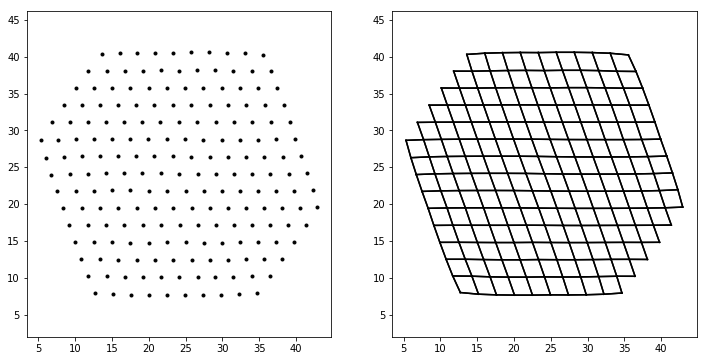

In [2]:
points = np.load('data/nanoparticle.npy')
adjacency = urquhart(points)

fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].plot(points[:,0], points[:,1], 'k.')
plotutils.graph_embedding(points, adjacency, ax = axes[1])
for ax in axes:
    ax.axis('equal')

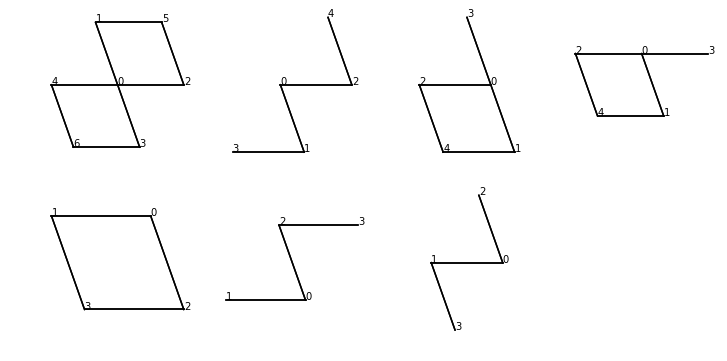

In [30]:
a = [1, 0]
b = [1/3., -2*np.sqrt(2)/3.]

templates = lattice_traversal(a, b, max_depth=3, graph_func=urquhart)
templates = templates[0].detach([0,1,2,3,4,5,9])

new_templates = templates.copy()
new_templates = new_templates[0].detach([0,2,3,5,6])
templates.extend(new_templates)

new_templates = templates.copy()
new_templates = new_templates[0].detach([0,1,3,4,6])
templates.extend(new_templates)

new_templates = templates.copy()
new_templates = new_templates[0].detach([0,2,3,4,6])
templates.extend(new_templates)

new_templates = templates.copy()
new_templates = new_templates[0].detach([0,3,4,6])
templates.extend(new_templates)

new_templates = templates.copy()
new_templates = new_templates[0].detach([0,1,4,5])
templates.extend(new_templates)

new_templates = templates.copy()
new_templates = new_templates[0].detach([0,1,4,6])
templates.extend(new_templates)

fig, axes = plt.subplots(2,4,figsize=(12,6))
axes = plotutils.show_structures(templates, axes.ravel(), show_order=True)
for ax in axes:
    ax.axis('equal')
    ax.axis('off')

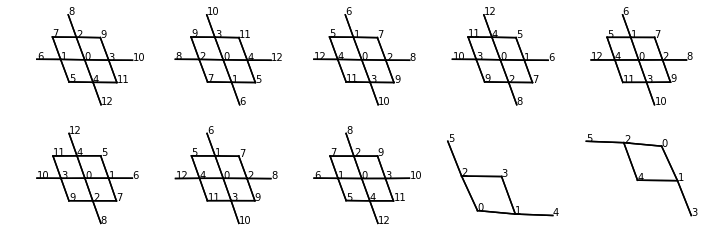

In [31]:
structures = traverse_from_all(points, adjacency, max_depth=3, max_per_point=1)

#structures = structures[40].detach()

fig,axes = plt.subplots(2,5,figsize=(12,4))
axes = plotutils.show_structures(structures, axes.ravel(), show_order=True)

for ax in axes.ravel():
    ax.axis('equal')
    ax.axis('off')

In [32]:
rmsd_calc = MatchGraph(transform='similarity', scale_invariant=True, pivot='front', subgraph_isomorphism=True)

rmsd = rmsd_calc.register(templates, structures)

 [||||||||||||||||||||] 1386/1386 registrations


C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\psm\register.py:449: RuntimeWarning: invalid value encountered in greater
  rmsd[rmsd > rmsd_max] = np.nan


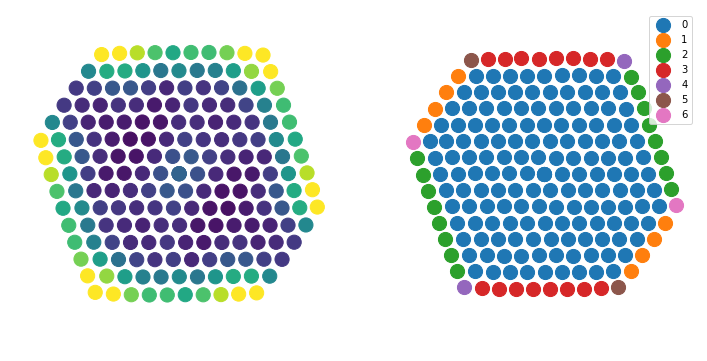

In [33]:
widest_match, best_rmsd = rmsd_calc.widest_matches(structures, rmsd_max=.1)

fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].scatter(structures.fronts[:,0], structures.fronts[:,1], c=best_rmsd, vmin=0, vmax=.02, s=200)

for label,color in zip(np.unique(widest_match), plt.cm.tab10.colors):
    fronts = structures.fronts[label == widest_match]
    axes[1].scatter(fronts[:,0], fronts[:,1], c=color, s=200, label=label)

axes[1].legend()
for ax in axes.ravel():
    ax.axis('equal')
    ax.axis('off')

In [35]:
unique, counts = np.unique(widest_match, return_counts=True)

print('Bulk:\t\t', counts[0])
print('<100>-facet:\t', counts[1])
print('<110>-facet:\t', counts[2]+counts[3])
print('Corner:\t\t', counts[4]+counts[5]+counts[6])

Bulk:		 152
<100>-facet:	 8
<110>-facet:	 32
Corner:		 6


In [39]:
strain, rotation = rmsd_calc.calc_strain(structures, 'widest', .1)
strain = transform.zero_median(strain)

C:\Users\jacob\Anaconda3\envs\point-segment-matching\lib\site-packages\psm\register.py:449: RuntimeWarning: invalid value encountered in greater
  rmsd[rmsd > rmsd_max] = np.nan


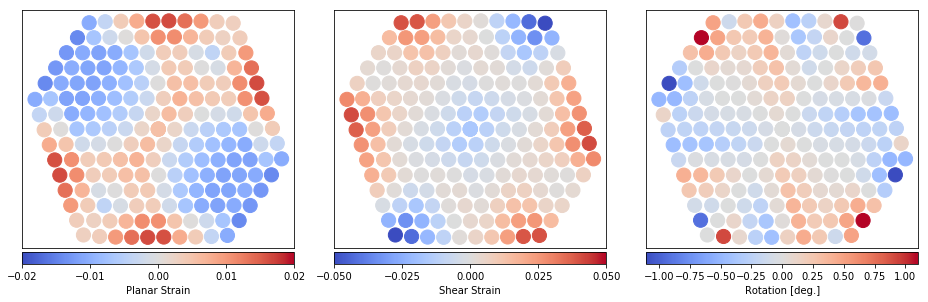

In [41]:
planar = transform.planar_strain(strain)
shear = strain[:,0,1]
transformed_rotation = ((rotation+np.pi/2) % (np.pi)) - np.pi/2

fig,axes = plt.subplots(1,3,figsize=(13,6))

p = axes[0].scatter(structures.fronts[:,0], structures.fronts[:,1],
                c=planar, cmap='coolwarm', vmin=-.02, vmax=.02, s=200)
plotutils.add_colorbar(p, axes[0], 'bottom', label='Planar Strain', ticks=np.linspace(-0.02,.02,5))

p = axes[1].scatter(structures.fronts[:,0], structures.fronts[:,1],
                c=shear, cmap='coolwarm', vmin=-.05, vmax=.05, s=200)
plotutils.add_colorbar(p, axes[1], 'bottom', label='Shear Strain', ticks=np.linspace(-0.05,.05,5))

p = axes[2].scatter(structures.fronts[:,0], structures.fronts[:,1],
                c=transformed_rotation/np.pi*180, cmap='coolwarm', s=200)
plotutils.add_colorbar(p, axes[2], 'bottom', label='Rotation [deg.]')

for ax in axes:
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

In [42]:
def reorient_strains(strain, labels, rotation, surface_directions):
    
    strain = strain.copy()
    for label in np.unique(labels):
        if label in surface_directions.keys():
            angles = surface_directions[label] - rotation[labels==label]
            strain[labels==label] = transform.rotate_strain(strain[labels==label], angles)
            
    return strain

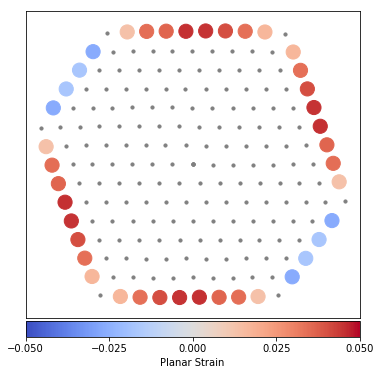

In [45]:
surface = np.isin(widest_match, [1,2,3])

surface_directions = {1: -np.arctan((a[0]+b[0]) / (a[1]+b[1])), 
                      2: np.arctan((b[1])/(b[0])),
                      3: 0}

rotated_strain = reorient_strains(strain, widest_match, rotation, surface_directions)

fig,ax = plt.subplots(1,1,figsize=(13,6))

ax.scatter(structures.fronts[:,0], structures.fronts[:,1], c='gray', s=10)

p = ax.scatter(structures.fronts[surface,0], structures.fronts[surface,1],
                c=rotated_strain[surface,1,1], cmap='coolwarm', vmin=-.05, vmax=.05, s=200)
plotutils.add_colorbar(p, ax, 'bottom', label='Planar Strain', ticks=np.linspace(-0.05,.05,5))

ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([]);

In [46]:
print('Average surface relaxations')
print('<100>: {:.3f} %'.format(np.mean(rotated_strain[widest_match==1,1,1])*100))
print('<110>: {:.3f} %'.format(np.mean(rotated_strain[np.isin(widest_match,[2,3]),1,1])*100))

Average surface relaxations
<100>: -2.182 %
<110>: 3.337 %
